# Lesson 5

Our goal is to match computer simulations to real experiments. Computer simulations are also cheaper to do and can be used to tell us if the real experiment can even answer the question we want to ask. The idea is to build the experiment synthetically first and then try to match against the synthetic data and see if under ideal circumstances if you can identify the parameters of interest. If you can't do it synthetically you can't do it in real life either which has many sources of error. Many times I have seen experiments run which turned out to have no chance of providing the required information because the experiment was run before figuring out what experiment should be run.

## Purpose

The goal of this section is to learn how to setup, run and analyze a parameter estimation run. 

The example used is from Lesson 1 which is a simple Dextran pulse through a column. This lesson will cover the the common variable transforms, scores and search algorithms.

## Load CADETSettings

This imports all the standard libraries, finds CADET and find and creates all the lesson folders.

In [1]:
%run CADETSettings.ipynb

CADET was found. Continue to the next step.


## Load simple example from Lesson 1
This code is pretty much the same as what we have looked at before. We open the file from Lesson 1 and then resave it to the Lesson 4 folder. We also run the simulation and save the output of the chromatogram as a CSV file to use in the matching process.

CompletedProcess(args=['C:/Users/kosh_000/CADET/cadet/bin/cadet-cli.exe', 'C:/Users/kosh_000/CADET/lessons/lesson_5/example_0/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


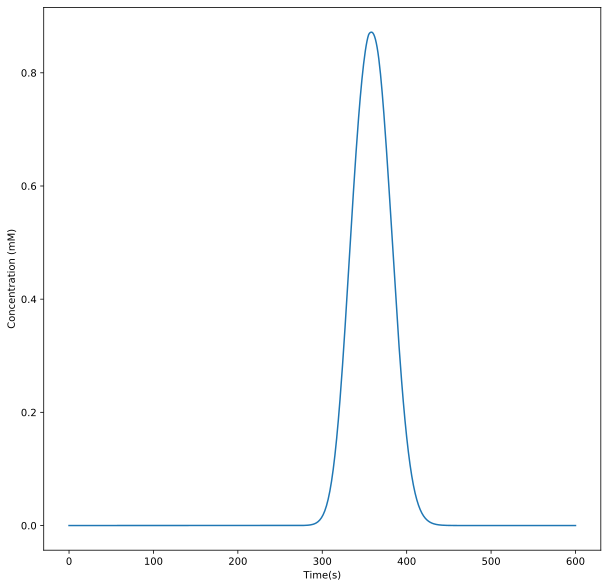

In [2]:
example_dir_0 = lesson_5 / "example_0"
example_dir_0.mkdir(exist_ok = True)

example0 = Cadet()

#give a filename for where the simulation should be saved
example0.filename = (lesson_1 / 'example_0' / 'example.h5').as_posix()

example0.load()

example0.filename = (example_dir_0 / 'example.h5').as_posix()

#save the simulation
example0.save()

#run the simulation
data = example0.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    example0.load()
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(example0.root.output.solution.solution_times,
        example0.root.output.solution.unit_002.solution_outlet_comp_000)
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    plt.show()
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([example0.root.output.solution.solution_times,
                        example0.root.output.solution.unit_002.solution_outlet_comp_000]).transpose()
    data.to_csv((example_dir_0 / 'example.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Try to optimize manually

First lets try just optimizing the function manually and looking at the result with sum squared error as a score.

In [3]:
def goal(axial_dispersion=-5, column_porosity=0.4):
    axial_dispersion = 10**axial_dispersion
    #create and run simulation
    example0_temp = Cadet(example0.root)
    example0_temp.filename = (example_dir_0 / 'example_temp.h5').as_posix()
    example0_temp.root.input.model.unit_001.col_dispersion = axial_dispersion
    example0_temp.root.input.model.unit_001.col_porosity = column_porosity
    example0_temp.save()
    example0_temp.run()
    example0_temp.load()
    
    #print error
    sse = numpy.sum( (example0.root.output.solution.unit_002.solution_outlet_comp_000 - example0_temp.root.output.solution.unit_002.solution_outlet_comp_000)**2 )   
    
    print('SSE %.3g' % sse)
    
    #create plots
    plt.figure(figsize=[15,10])
    plt.plot(example0.root.output.solution.solution_times,
        example0.root.output.solution.unit_002.solution_outlet_comp_000, label='Goal')
    plt.plot(example0.root.output.solution.solution_times,
        example0_temp.root.output.solution.unit_002.solution_outlet_comp_000, label='Test')
    plt.legend()
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
style = {'description_width': 'initial'}
interact(goal, axial_dispersion=widgets.FloatSlider(min=-10, max=-5, step=0.1, layout={'width': '800px'}, style=style, description="Axial Dispersion"),
        column_porosity=widgets.FloatSlider(min=0.1, max=0.9, step=0.01, layout={'width': '800px'}, style=style, description='Column Porosity'))

interactive(children=(FloatSlider(value=-5.0, description='Axial Dispersion', layout=Layout(width='800px'), ma…

<function __main__.goal(axial_dispersion=-5, column_porosity=0.4)>

## Create CADETMatch configuration

This is a configuration needed for CADETMatch to run. This one is setup to run gradient descent from a single starting location. 

For now we are just going to create this object and explain it later. 

In [4]:
def create_match0(ax_dis, col_por):
    match = Dict()
    match.CADETPath = cadet_path.as_posix()
    match.baseDir = example_dir_0.as_posix()
    match.resultsDir = 'fit_grad'
    match.searchMethod = 'Gradient'
    match.seeds = [(ax_dis, col_por), ]
    match.gradVector = True
    
    parameter1 = Dict()
    parameter1.transform = 'null'
    parameter1.component = -1
    parameter1.bound = -1
    parameter1.location = "/input/model/unit_001/COL_DISPERSION"
    parameter1.min = 1e-10
    parameter1.max = 1e-5

    parameter2 = Dict()
    parameter2.transform = 'null'
    parameter2.component = -1
    parameter2.bound = -1
    parameter2.location = "/input/model/unit_001/COL_POROSITY"
    parameter2.min = 0.1
    parameter2.max = 0.9

    match.parameters = [parameter1, parameter2]

    experiment1 = Dict()
    experiment1.csv = "example.csv"
    experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
    experiment1.HDF5 = "example.h5"
    experiment1.name = "main"
 
    feature1 = Dict()
    feature1.name = "Pulse"
    feature1.type = 'SSE'

    experiment1.features = [feature1,]

    match.experiments = [experiment1,]

    return match   

## Find a starting point for gradient search and then run it

Below is a lot of code designed to make the gui work. In practice all it is doing is allowing you to choose a starting point for gradient search by moving the sliders and then starting the search once you click the button. 

Go ahead and play around with it to see what happens when you look at different starting points.

In [5]:
style = {'description_width': 'initial'}
axial_dispersion0=widgets.FloatSlider(min=-10, max=-5, step=0.1, layout={'width': '800px'}, style=style, description="Axial Dispersion")
column_porosity0=widgets.FloatSlider(min=0.1, max=0.9, step=0.01, layout={'width': '800px'}, style=style, description='Column Porosity')
button0 = widgets.Button(description='Start Gradient Search')

output0 = widgets.Output()
output_graph0 = widgets.Output()
output_search0 = widgets.Output()

import matplotlib

def click_search0(b):
    with output0:
        clear_output(wait=True)
        print("Axial Dispersion", 10**axial_dispersion0.value)
        print("Column Porosity", column_porosity0.value)

    with output_search0:
        clear_output(wait=True)
        
        match = create_match0(10**axial_dispersion0.value, column_porosity0.value)

        match_file = example_dir_0 / 'example.json'

        with (match_file).open('w') as json_file:
            json.dump(match.to_dict(), json_file, indent='\t')
            
        match = simple_run_match(match, match_file, delete=True)

    best ,score, best_score = match.get_best()

    for data in best_score.values():
        axial_dispersion0.value = numpy.log10(data[0])
        column_porosity0.value = data[1]
        
        axial_dispersion_best = numpy.log10(data[0])
        column_porosity_best = data[1]

        goal0(axial_dispersion_best, column_porosity_best)
        break
        

def goal0(axial_dispersion=-5, column_porosity=0.4):
    axial_dispersion = 10**axial_dispersion

    with output0:
        clear_output(wait=True)
        print("Axial Dispersion %.3g" % axial_dispersion)
        print("Column Porosity %.3g" % column_porosity)

        #create and run simulation
        example0_temp = Cadet(example0.root)
        example0_temp.filename = (example_dir_0 / 'example_temp.h5').as_posix()
        example0_temp.root.input.model.unit_001.col_dispersion = axial_dispersion
        example0_temp.root.input.model.unit_001.col_porosity = column_porosity
        example0_temp.save()
        example0_temp.run()
        example0_temp.load()

        #print error
        sse = numpy.sum( (example0.root.output.solution.unit_002.solution_outlet_comp_000 - example0_temp.root.output.solution.unit_002.solution_outlet_comp_000)**2 )   

        print('SSE %.3g' % sse)

    with output_graph0:
        clear_output(wait=True)
        #create plots
        plt.figure(figsize=[15,6])
        plt.plot(example0.root.output.solution.solution_times,
            example0.root.output.solution.unit_002.solution_outlet_comp_000, label='Goal')
        plt.plot(example0_temp.root.output.solution.solution_times,
            example0_temp.root.output.solution.unit_002.solution_outlet_comp_000, label='Test')
        plt.legend()
        plt.xlabel('Time(s)')
        plt.ylabel('Concentration (mM)')
        plt.show()
     
button0.on_click(click_search0)

call_goal = interactive(goal0, axial_dispersion=axial_dispersion0, column_porosity=column_porosity0)

vbox = widgets.VBox([call_goal, button0, output0, output_graph0, output_search0])

display(vbox)

# Lets try this with Langmuir

Lets try the same process with a simple single component Langmuir isotherm.

First we create the simulation and run it to verify it works.

Simulation completed successfully


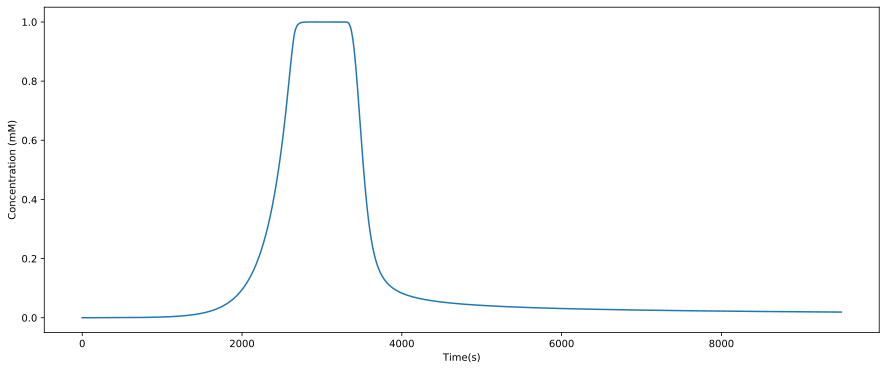

In [6]:
#simple model
example_dir_1 = lesson_5 / "example_1"
example_dir_1.mkdir(exist_ok = True)

example1 = Cadet(example0.root)

#give a filename for where the simulation should be saved
example1.filename = (example_dir_1 / 'example.h5').as_posix()

#change the column
example1.root.input.model.unit_001.adsorption_model = 'MULTI_COMPONENT_LANGMUIR'

example1.root.input.model.unit_001.adsorption.is_kinetic = 1
example1.root.input.model.unit_001.adsorption.mcl_ka = [1.144,]
example1.root.input.model.unit_001.adsorption.mcl_kd = [2.0e-3,]
example1.root.input.model.unit_001.adsorption.mcl_qmax = [4.88,]

example1.root.input.model.unit_001.film_diffusion = [2.0E-7,]
example1.root.input.model.unit_001.par_diffusion = [1e-8,]
example1.root.input.model.unit_001.discretization.nbound = [1,]

#solver settings
example1.root.input.solver.sections.section_times = [0.0, 3000.0, 9500.0]

#set the times that the simulator writes out data for
example1.root.input.solver.user_solution_times = numpy.linspace(0, example1.root.input.solver.sections.section_times[-1], 
                                                               int(example1.root.input.solver.sections.section_times[-1]) + 1)

example1.save()


#run the simulation
data = example1.run()

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    example1.load()
    
    #plot the simulation
    plt.figure(figsize=[15,6])
    plt.plot(example1.root.output.solution.solution_times,
        example1.root.output.solution.unit_002.solution_outlet_comp_000)
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([example1.root.output.solution.solution_times,
                        example1.root.output.solution.unit_002.solution_outlet_comp_000]).transpose()
    data.to_csv((example_dir_1 / 'example.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Create CADETMatch configuration

Once again this is a gradient descent setup with a single starting location. 

We will start looking at how these configurations are created in the next example.

In [7]:
def create_match1(ka, kd, qmax):
    match = Dict()
    match.CADETPath = cadet_path.as_posix()
    match.baseDir = example_dir_1.as_posix()
    match.resultsDir = 'fit_grad'
    match.searchMethod = 'Gradient'
    match.seeds = [(ka, kd, qmax), ]
    match.gradVector = True
    
    parameter1 = Dict()
    parameter1.transform = 'null'
    parameter1.component = 0
    parameter1.bound = 0
    parameter1.location = "/input/model/unit_001/adsorption/MCL_KA"
    parameter1.min = 1e-5
    parameter1.max = 1e5

    parameter2 = Dict()
    parameter2.transform = 'null'
    parameter2.component = 0
    parameter2.bound = 0
    parameter2.location = "/input/model/unit_001/adsorption/MCL_KD"
    parameter2.min = 1e-5
    parameter2.max = 1e5
    
    parameter3 = Dict()
    parameter3.transform = 'null'
    parameter3.component = 0
    parameter3.bound = 0
    parameter3.location = "/input/model/unit_001/adsorption/MCL_QMAX"
    parameter3.min = 1
    parameter3.max = 20

    match.parameters = [parameter1, parameter2, parameter3]

    experiment1 = Dict()
    experiment1.csv = "example.csv"
    experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
    experiment1.HDF5 = "example.h5"
    experiment1.name = "main"
 
    feature1 = Dict()
    feature1.name = "Pulse"
    feature1.type = 'SSE'

    experiment1.features = [feature1,]

    match.experiments = [experiment1,]

    return match   

## Now Lets use CADETMatch with gradient search to optimize

First start off trying to optimize by hand with the sliders. You may not want to run the search now but you can run it later just to see what it does.

**Once you click the search button it could take 5-10 minutes to run and will prevent running other examples until it completes.**

In [8]:
style = {'description_width': 'initial'}
ka1 = widgets.FloatSlider(min=-5, max=5, step=0.1, layout={'width': '800px'}, style=style, description="kA")
kd1 = widgets.FloatSlider(min=-5, max=5, step=0.1, layout={'width': '800px'}, style=style, description='kD')
qmax1 = widgets.FloatSlider(min=1, max=20, step=0.1, layout={'width': '800px'}, style=style, description='qmax')
button1 = widgets.Button(description='Start Gradient Search')

output1 = widgets.Output()
output_graph1 = widgets.Output()
output_search1 = widgets.Output()

import matplotlib

def click_search1(b):
    with output1:
        clear_output(wait=True)
        print("kA %.3g" % 10**ka1.value)
        print("kD %.3g" % 10**kd1.value)
        print("qmax %.3g" % qmax1.value)
        
    with output_search1:
        clear_output(wait=True)
        
        match = create_match1(10**ka1.value, 10**kd1.value, qmax1.value)

        match_file = example_dir_1 / 'example.json'

        with (match_file).open('w') as json_file:
            json.dump(match.to_dict(), json_file, indent='\t')
            
        match = simple_run_match(match, match_file, delete=True)

    best ,score, best_score = match.get_best()

    for data in best_score.values():
        ka1.value = numpy.log10(data[0])
        kd1.value = numpy.log10(data[1])
        qmax1.value = data[2]
        
        ka_best = numpy.log10(data[0])
        kd_best = numpy.log10(data[1])
        qmax_best = data[2]

        goal1(ka_best, kd_best, qmax_best)
        break
        

def goal1(ka=1, kd=-1, qmax=4):
    ka = 10**ka
    kd = 10**kd

    with output1:
        clear_output(wait=True)
        print("kA %.3g" % ka)
        print("kD %.3g" % kd)
        print("qmax %.3g" % qmax)

        #create and run simulation
        example1_temp = Cadet(example1.root)
        example1_temp.filename = (example_dir_1 / 'example_temp.h5').as_posix()
        example1_temp.root.input.model.unit_001.adsorption.mcl_ka = ka
        example1_temp.root.input.model.unit_001.adsorption.mcl_kd = kd
        example1_temp.root.input.model.unit_001.adsorption.mcl_qmax = qmax
        example1_temp.save()
        example1_temp.run()
        example1_temp.load()

        #print error
        sse = numpy.sum( (example1.root.output.solution.unit_002.solution_outlet_comp_000 - example1_temp.root.output.solution.unit_002.solution_outlet_comp_000)**2 )   

        print('SSE %.3g' % sse)

    with output_graph1:
        clear_output(wait=True)
        #create plots
        plt.figure(figsize=[15,6])
        plt.plot(example1.root.output.solution.solution_times,
            example1.root.output.solution.unit_002.solution_outlet_comp_000, label='Goal')
        plt.plot(example1_temp.root.output.solution.solution_times,
            example1_temp.root.output.solution.unit_002.solution_outlet_comp_000, label='Test')
        plt.legend()
        plt.xlabel('Time(s)')
        plt.ylabel('Concentration (mM)')
        plt.show()
     
button1.on_click(click_search1)

call_goal1 = interactive(goal1, ka=ka1, kd=kd1, qmax=qmax1)

vbox = widgets.VBox([call_goal1, button1, output1, output_graph1, output_search1])

display(vbox)

# Create a new simulation and look at variable transforms

First lets copy the simulation and run it again to verify everything works.

CompletedProcess(args=['C:/Users/kosh_000/CADET/cadet/bin/cadet-cli.exe', 'C:/Users/kosh_000/CADET/lessons/lesson_5/example_2/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


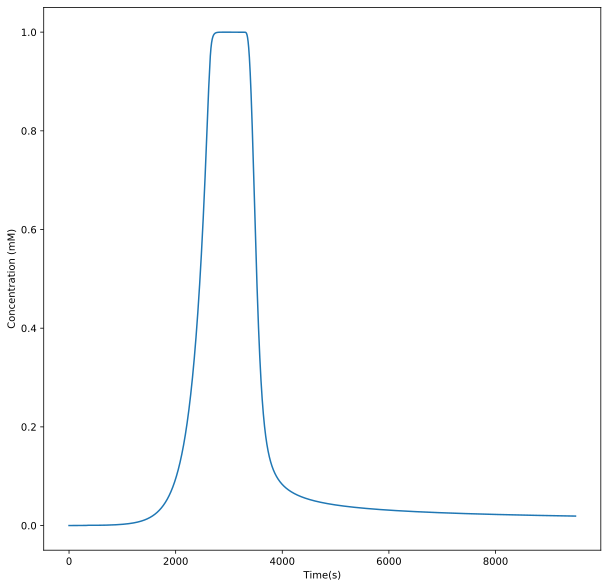

In [9]:
example_dir_2 = lesson_5 / "example_2"
example_dir_2.mkdir(exist_ok = True)

example2 = Cadet(example1.root)

example2.filename = (example_dir_2 / 'example.h5').as_posix()

#save the simulation
example2.save()

#run the simulation
data = example2.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    example2.load()
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(example2.root.output.solution.solution_times,
        example2.root.output.solution.unit_002.solution_outlet_comp_000)
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    plt.show()
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([example2.root.output.solution.solution_times,
                        example2.root.output.solution.unit_002.solution_outlet_comp_000]).transpose()
    data.to_csv((example_dir_2 / 'example.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Variable transforms

Search algorithms don't work well when the parameters have very different ranges. For example if one parmeter varies from 1e-5 to 1e-10 and the other varies from 1-10. Another problem is when parameters are tightly coupled together but presented to the optimizer as indepdent variables. This is true with kA and kD for the adsorption and desorption rates. The parameters kA and kD are coupled together but given as two different variables while they do not freely vary from each other. To solve this problem variable transforms are available. I will cover the most common and useful transformations. There are some other variable transforms available that you can see at https://github.com/modsim/CADET-Match/tree/master/CADETMatch/transform

1. norm

  This is a simple transform that normalizes a variable from 0 to 1. This is best used when you have a variable that varies over less then 3 orders of magnitude.
  
  ```json
{
      "transform": "norm",
      "component": -1,
      "bound": -1,
      "location": "/input/model/unit_001/COL_POROSITY",
      "min": 0.2,
      "max": 0.5
    }
```

  ```python
parameter = Dict()
parameter.transform = 'norm'
parameter.component = -1
parameter.bound = -1
parameter.location = "/input/model/unit_001/COL_POROSITY"
parameter.min = 0.2
parameter.max = 0.5
```
  
2. norm_log

  This transform takes the log before normalizing the variable from 0 to 1. Use this transform when your variable spans more than 3 orders of magnitude.
  
    ```json
{
      "transform": "norm_log",
      "component": -1,
      "bound": -1,
      "location": "/input/model/unit_001/COL_DISPERSION",
      "min": 1e-12,
      "max": 1e-5
    }
```

  ```python
parameter = Dict()
parameter.transform = 'norm_log'
parameter.component = -1
parameter.bound = -1
parameter.location = "/input/model/unit_001/COL_DISPERSION"
parameter.min = 1e-12
parameter.max = 1e-5
```
  
3. norm_keq

   This transform turns ka, kd in ka and keq=ka/kd and then takes a log transform and normalizes from 0 to 1.

   ```json
{
    "transform": "norm_keq",
    "component": 0,
    "bound": 0,
    "location": [
        "/input/model/unit_001/adsorption/LIN_KA",
        "/input/model/unit_001/adsorption/LIN_KD"
    ],
    "minKA": 1e-8,
    "maxKA": 1e8,
    "minKEQ": 1e-4,
    "maxKEQ": 1e4
}
```
  ```python
parameter = Dict()
parameter.transform = 'norm_keq'
parameter.component = 0
parameter.bound = 0
parameter.location = ["/input/model/unit_001/adsorption/LIN_KA",
                      "/input/model/unit_001/adsorption/LIN_KD"]
parameter.minKA = 1e-8
parameter.maxKA = 1e8
parameter.minKEQ = 1e-4
parameter.maxKEQ = 1e4
```


4. norm_volume_area

    This transform and the following one where created to solve the same common problem. When fitting bypass data and you model the tubing you are fitting the length, crosssectional area and dispersion of the tubing. Dispersion though is tied to the length such that a shorter length can just be compensated for with a higher diffusion. Basically we have fewer degrees of freedom that we are fitting with and since this is not a fluid dynamics model it is not physically accurate. This transformation couples the length and area together through the volume since volume is an identfiable quantity (since water is incompressible). We don't actually care much about the parameters for the tubing, it is just there to fill in for the real tubing so that fewer errors are carried into the column. Use this version if it is easier to measure the diameter of the tubing and use the other transform if measuring the length is easier. I just depends on your experimental setup.



```json
{
  "transform": "norm_volume_area",
  "area_location": "/input/model/unit_003/COL_DISPERSION",
  "length_location": "/input/model/unit_004/COL_DISPERSION",
  "component": -1,
  "bound": -1,
  "minVolume":1e-6,
  "maxVolume":1e-5,
  "minArea":1e-4,
  "maxArea":1e-3  
}```

  ```python
parameter = Dict()
parameter.transform = 'norm_volume_area'
parameter.area_location = "/input/model/unit_003/COL_DISPERSION"
parameter.length_location = "/input/model/unit_004/COL_DISPERSION"
parameter.component = -1
parameter.bound = -1
parameter.minVolume = 1e-6
parameter.maxVolume = 1e-5
parameter.minArea = 1e-4
parameter.maxArea = 1e-3
```
    

5. norm_volume_length

    Use this transform if measuring the length accurately is easier than measuring the diameter of the tubing. If you are lumping together all the tubing in front of the column or after the column together and you have multiple diameters it doesn't matter which of these transforms you choose.

```json
{
  "transform": "norm_volume_length",
  "area_location": "/input/model/unit_003/COL_DISPERSION",
  "length_location": "/input/model/unit_004/COL_DISPERSION",
  "component": -1,
  "bound": -1,
  "minVolume":1e-6,
  "maxVolume":1e-5,
  "minLength":0.25,
  "maxLength":0.75  
}```

  ```python
parameter = Dict()
parameter.transform = 'norm_volume_area'
parameter.area_location = "/input/model/unit_003/COL_DISPERSION"
parameter.length_location = "/input/model/unit_004/COL_DISPERSION"
parameter.component = -1
parameter.bound = -1
parameter.minVolume = 1e-6
parameter.maxVolume = 1e-5
parameter.minLength = 0.25
parameter.maxLength = 0.75
```


6. set_value

    This is a different kind of transform. What it allows you to do is copy a value from place to another. This is important if you are estimating axial dispersion for identical tubing in front of and behind the column. You want the same axial dispersion for both pieces of tubing but you only want to estimate one variable. With this you can estimate axial dispersion for the first piece of tubing and then copy the value over to the other piece of tubing. This is also required if you want to estimate SMA_LAMDA. Whenever SMA_LAMBDA change the initial bound salt concentration also much change or electronuetrality would be violated.
    
```json
{
  "transform": "set_value",
  "componentFrom": -1,
  "boundFrom": -1,
  "locationFrom": "/input/model/unit_003/COL_DISPERSION",
  "componentTo": -1,
  "boundTo": -1,
  "locationTo": "/input/model/unit_004/COL_DISPERSION"
}```

```python
parameter = Dict()
parameter.transform = 'set_value'
parameter.componentFrom = -1
parameter.boundFrom = -1
parameter.locationFrom = "/input/model/unit_001/COL_DISPERSION"
parameter.componentTo = -1
parameter.boundTo = -1
parameter.locationTo = "/input/model/unit_001/COL_DISPERSION"
```  

In [10]:
def create_match2(ka, kd, qmax):
    match = Dict()
    match.CADETPath = cadet_path.as_posix()
    match.baseDir = example_dir_2.as_posix()
    match.resultsDir = 'fit_grad'
    match.searchMethod = 'Gradient'
    match.seeds = [(ka, kd, qmax), ]
    match.gradVector = True
    
    #variable transforms
    parameter1 = Dict()
    
    #use the norm_keq transform
    parameter1.transform = 'norm_keq'
    
    #this is the component, in this case we want component 0
    parameter1.component = 0
    
    #this is the bound state we are looking at, this is usually 0 unless you are using multi-state binding
    parameter1.bound = 0
    
    #norm_keq location takes a list with the path to ka and the path to kd in the file
    parameter1.location = ["/input/model/unit_001/adsorption/MCL_KA", "/input/model/unit_001/adsorption/MCL_KD"]
    
    #minimm and maximum values for the search
    parameter1.minKA = 1e-5
    parameter1.maxKA = 1e5
    parameter1.minKEQ = 1e-4
    parameter1.maxKEQ = 1e4

    parameter2 = Dict()
    parameter2.transform = 'norm'
    parameter2.component = 0
    parameter2.bound = 0
    parameter2.location = "/input/model/unit_001/adsorption/MCL_QMAX"
    parameter2.min = 1
    parameter2.max = 20

    match.parameters = [parameter1, parameter2, ]

    experiment1 = Dict()
    experiment1.csv = "example.csv"
    experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
    experiment1.HDF5 = "example.h5"
    experiment1.name = "main"
 
    feature1 = Dict()
    feature1.name = "Pulse"
    feature1.type = 'SSE'

    experiment1.features = [feature1,]

    match.experiments = [experiment1,]

    return match   

## Lets look at optimization again with the transformed variables

Now that we have transformed from ka and kd to ka and keq and used a log transform to better search the space and normalized the range from 0 to 1 for all the variables lets see how searching works.

Try to optimize manually a bit and then run gradient search when you are ready.

In [11]:
style = {'description_width': 'initial'}
ka2 = widgets.FloatSlider(min=-5, max=5, step=0.1, layout={'width': '800px'}, style=style, description="kA")
keq2 = widgets.FloatSlider(min=-4, max=4, step=0.1, layout={'width': '800px'}, style=style, description='kEQ')
qmax2 = widgets.FloatSlider(min=1, max=20, step=0.1, layout={'width': '800px'}, style=style, description='qmax')
button2 = widgets.Button(description='Start Gradient Search')

output2 = widgets.Output()
output_graph2 = widgets.Output()
output_search2 = widgets.Output()

import matplotlib

def click_search2(b):
    with output2:
        clear_output(wait=True)
        print("kA %.3g" % 10**ka2.value)
        print("kD %.3g" % (10**ka2.value/10**keq2.value))
        print("kEQ %.3g" % 10**keq2.value)
        print("qmax %.3g" % qmax2.value)
        
    with output_search2:
        clear_output(wait=True)
        
        match = create_match2(10**ka2.value, 10**keq2.value, qmax2.value)

        match_file = example_dir_2 / 'example.json'

        with (match_file).open('w') as json_file:
            json.dump(match.to_dict(), json_file, indent='\t')
            
        match = simple_run_match(match, match_file, delete=True)

    best ,score, best_score = match.get_best()

    for data in best_score.values():
        ka2.value = numpy.log10(data[0])
        keq2.value = numpy.log10(data[2])
        qmax2.value = data[3]
        
        ka_best = numpy.log10(data[0])
        keq_best = numpy.log10(data[2])
        qmax_best = data[3]

        goal2(ka_best, keq_best, qmax_best)
        break
        

def goal2(ka=1, keq=-1, qmax=4):
    ka = 10**ka
    keq = 10**keq

    with output2:
        clear_output(wait=True)
        print("kA %.3g" % ka)
        print("kD %.3g" % (ka/keq))
        print("kEQ %.3g" % keq)
        print("qmax %.3g" % qmax)

        #create and run simulation
        example2_temp = Cadet(example2.root)
        example2_temp.filename = (example_dir_1 / 'example_temp.h5').as_posix()
        example2_temp.root.input.model.unit_001.adsorption.mcl_ka = ka
        example2_temp.root.input.model.unit_001.adsorption.mcl_kd = ka/keq
        example2_temp.root.input.model.unit_001.adsorption.mcl_qmax = qmax
        example2_temp.save()
        example2_temp.run()
        example2_temp.load()

        #print error
        sse = numpy.sum( (example2.root.output.solution.unit_002.solution_outlet_comp_000 - example2_temp.root.output.solution.unit_002.solution_outlet_comp_000)**2 )   

        print('SSE %.3g' % sse)

    with output_graph2:
        clear_output(wait=True)
        #create plots
        plt.figure(figsize=[15,6])
        plt.plot(example2.root.output.solution.solution_times,
            example2.root.output.solution.unit_002.solution_outlet_comp_000, label='Goal')
        plt.plot(example2_temp.root.output.solution.solution_times,
            example2_temp.root.output.solution.unit_002.solution_outlet_comp_000, label='Test')
        plt.legend()
        plt.xlabel('Time(s)')
        plt.ylabel('Concentration (mM)')
        plt.show()
     
button2.on_click(click_search2)

call_goal2 = interactive(goal2, ka=ka2, keq=keq2, qmax=qmax2)

vbox = widgets.VBox([call_goal2, button2, output2, output_graph2, output_search2])

display(vbox)

## Variable transformations are important

We have now solved the same problem twice. Once without variable transforms and once with variable transforms. Using the varible transforms the problem is solved in about half the time and also more accurately. 

In the next lesson we will look at automatically choosing starting points and other types of search algorithms.